## Accessing NOAA's Global Ocean Heat Content Climate Data Record (CDR) with the Planetary Computer STAC API

The Ocean Heat Content Climate Data Record (CDR) is a set of ocean heat content anomaly (OHCA) time-series for 1955–present on 3-monthly, yearly, and pentadal (five-yearly) scales. This CDR quantifies ocean heat content change over time, which is an essential metric for understanding climate change and the Earth’s energy budget. It provides time-series for multiple depth ranges in the global ocean and each of the major basins (Atlantic, Pacific, and Indian) divided by hemisphere (Northern, Southern). 

### Data access

This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. The [Planetary Computer Hub](https://planetarycomputer.microsoft.com/compute) sets the environment variable "PC_SDK_SUBSCRIPTION_KEY" when your server is started. When your Planetary Computer [account request](https://planetarycomputer.microsoft.com/account/request) was approved, a pair of subscription keys were automatically generated for you. You can view your keys by singing in to the [developer portal](https://planetarycomputer.developer.azure-api.net/). The API key may be set manually via the following code:

```python
pc.settings.set_subscription_key(<YOUR API Key>)
```

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more. 

The Ocean Heat Content CDR includes data over multiple time intervals, and for multiple maximum ocean depths.
Let's use the [Collection summaries](https://github.com/radiantearth/stac-spec/blob/master/collection-spec/collection-spec.md#summaries) to see what values are available.

In [8]:
import planetary_computer
import pystac_client
from rich.table import Table

client = pystac_client.Client.open(
    "https://pct-apis-staging.westeurope.cloudapp.azure.com/stac",
    modifier=planetary_computer.sign_inplace,
)
collection = client.get_collection(
    "noaa-cdr-ocean-heat-content",
)

table = Table("Key", "Value")
for key, value in collection.summaries.to_dict().items():
    table.add_row(key, str(value))
table

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                ┃ Value                                         ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ noaa_cdr:interval  │ ['monthly', 'seasonal', 'yearly', 'pentadal'] │
│ noaa_cdr:max_depth │ [100, 700, 2000]                              │
└────────────────────┴───────────────────────────────────────────────┘

For this example, let's work with the most recent yearly items with a maximum depth of 700m.
We'll use [CQL2](https://pystac-client.readthedocs.io/en/latest/tutorials/cql2-filter.html) to build our query.

In [9]:
item_search = client.search(
    max_items=10,
    collections=["noaa-cdr-ocean-heat-content"],
    filter={
        "op": "and",
        "args": [
            {
                "op": "=",
                "args": [{"property": "noaa_cdr:interval"}, "yearly"],
            },
            {
                "op": "=",
                "args": [{"property": "noaa_cdr:max_depth"}, 700],
            },
        ],
    },
    sortby="-datetime",
)
items = list(item_search.items())
print(items)

[<Item id=ocean-heat-content-2020-700m>, <Item id=ocean-heat-content-2019-700m>, <Item id=ocean-heat-content-2018-700m>, <Item id=ocean-heat-content-2017-700m>, <Item id=ocean-heat-content-2016-700m>, <Item id=ocean-heat-content-2015-700m>, <Item id=ocean-heat-content-2014-700m>, <Item id=ocean-heat-content-2013-700m>, <Item id=ocean-heat-content-2012-700m>, <Item id=ocean-heat-content-2011-700m>]


### Assets

Each item has a Cloud Optimized GeoTIFF (COG) asset containing several computed values.
We'll focus on the `heat_content` asset for this example.

In [10]:
item = items[0]
table = Table("Key", "Title")
for key, asset in item.assets.items():
    table.add_row(key, asset.title)
table

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Key                         ┃ Title                                                          ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ heat_content                │ Ocean Heat Content anomalies from WOA09 : 0-700m 2020          │
│ mean_salinity               │ Mean salinity anomalies from WOA09 : 0-700m 2020               │
│ mean_temperature            │ Mean temperature anomalies from WOA09 : 0-700m 2020            │
│ mean_halosteric_sea_level   │ Mean halosteric sea level anomalies from WOA09 : 0-700m 2020   │
│ mean_thermosteric_sea_level │ Mean thermosteric sea level anomalies from WOA09 : 0-700m 2020 │
│ mean_total_steric_sea_level │ Mean total steric sea level anomalies from WOA09 : 0-700m 2020 │
│ tilejson                    │ TileJSON with default rendering                                │
│ rendered_preview            │ Rendered preview                                               │
└─────────────────────────────┴────────────────────────────────────────────────────────────────┘

### Load data

Let's load all the data into an xarray using [odc-stac](https://github.com/opendatacube/odc-stac).

In [11]:
import odc.stac

data = odc.stac.load(items, bands="heat_content")
data

<xarray.Dataset>
Dimensions:       (latitude: 180, longitude: 360, time: 10)
Coordinates:
  * latitude      (latitude) float64 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * longitude     (longitude) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    spatial_ref   int32 4326
  * time          (time) datetime64[ns] 2011-01-01 2012-01-01 ... 2020-01-01
Data variables:
    heat_content  (time, latitude, longitude) float32 0.04893 0.04917 ... nan

### Visualize

Now, let's visualize one year's heat content.

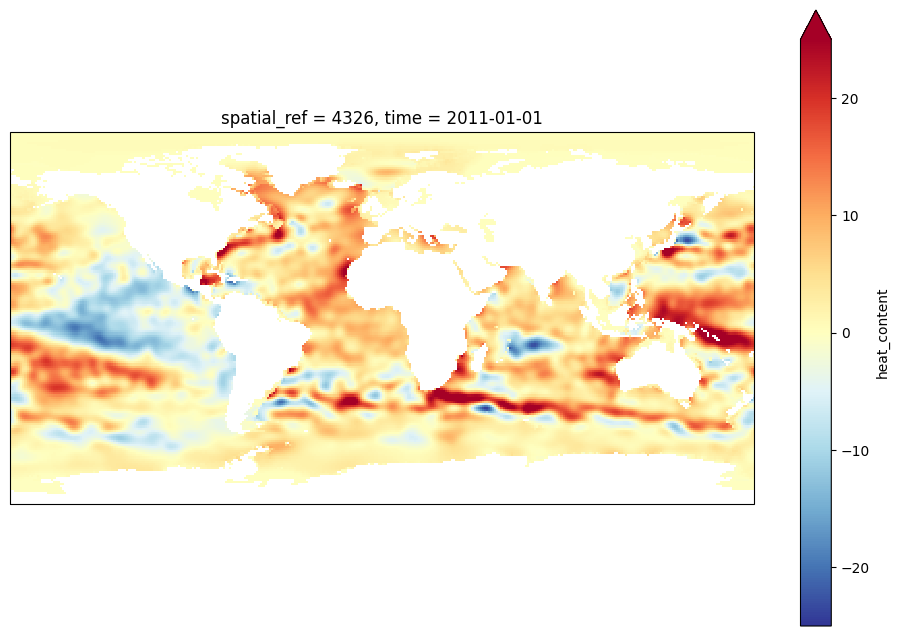

In [12]:
from cartopy import crs
from matplotlib import pyplot

figure = pyplot.figure(figsize=(12, 8))
axes = pyplot.axes(projection=crs.Mercator())
data["heat_content"][0].plot.imshow(cmap="RdYlBu_r", vmin=-25, vmax=25)

### NetCDF data

We recommend using the Cloud-Optimized GeoTIFF assets provided by the `noaa-cdr-ocean-heat-content` collection, but if you'd like to use the source NetCDFs that the COGs were created from, you can as well.
Those are stored in the `noaa-cdr-ocean-heat-content-netcdf` collection.

In [13]:
item_search = client.search(
    max_items=10,
    collections=["noaa-cdr-ocean-heat-content-netcdf"],
    filter={
        "op": "and",
        "args": [
            {
                "op": "=",
                "args": [{"property": "noaa_cdr:interval"}, "monthly"],
            },
            {
                "op": "=",
                "args": [{"property": "noaa_cdr:max_depth"}, 2000],
            },
        ],
    },
    sortby="-datetime",
)
items = list(item_search.items())
print(items)

[<Item id=heat_content_anomaly_0-2000_monthly>]


You can use `xarray` (via `fsspec`) to access the data in the NetCDF.

<xarray.Dataset>
Dimensions:             (lat: 180, nbounds: 2, lon: 360, depth: 1, time: 192)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time                (time) float32 0.5 1.5 2.5 3.5 ... 189.5 190.5 191.5
Dimensions without coordinates: nbounds, depth
Data variables: (12/31)
    crs                 int32 ...
    lat_bnds            (lat, nbounds) float32 ...
    lon_bnds            (lon, nbounds) float32 ...
    depth_bnds          (depth, nbounds) float32 ...
    climatology_bounds  (time, nbounds) float32 ...
    h18_hc              (time, depth, lat, lon) float32 ...
    ...                  ...
    month_h22_se_IO     (time) float32 ...
    month_h22_NI        (time) float32 ...
    month_h22_se_NI     (time) float32 ...
    month_h22_SI        (time) float32 ...
    month_h22_se_SI     (time) float32 ...
    basin_mask          (lat, lon) float64 ...
Attributes: (12/45)
    Conventions:                     CF-1.6
    title:                           Ocean Heat Content anomalies from WOA09 ...
    summary:                         Mean ocean variable anomaly from in situ...
    references:                      Levitus, S., J. I. Antonov, T. P. Boyer,...
    institution:                     National Oceanographic Data Center(NODC)
    comment:                         
    ...                              ...
    publisher_name:                  US NATIONAL OCEANOGRAPHIC DATA CENTER
    publisher_url:                   http://www.nodc.noaa.gov/
    publisher_email:                 NODC.Services@noaa.gov
    license:                         These data are openly available to the p...
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    metadata_link:                   http://www.nodc.noaa.gov/OC5/3M_HEAT_CON...

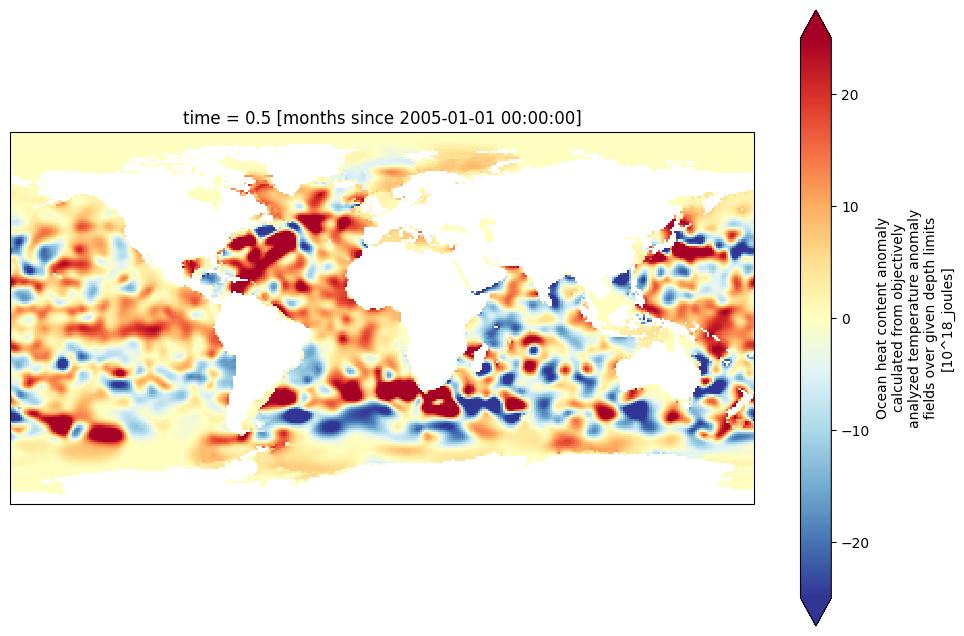

In [14]:
import fsspec
import xarray
from IPython.display import display

figure = pyplot.figure(figsize=(12, 8))
axes = pyplot.axes(projection=crs.Mercator())
with fsspec.open(items[0].assets["netcdf"].href) as file:
    with xarray.open_dataset(file, decode_times=False) as dataset:
        display(dataset)
        dataset["h18_hc"].isel(time=0).squeeze().plot.imshow(
            cmap="RdYlBu_r", vmin=-25, vmax=25
        )